In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eeg-signal/model.pt
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A04E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A03E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A09E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A06E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A05E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A07E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A08E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A02E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A01E.gdf
/kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf
/kaggle/input/eeg-signal/normalized/train_data.csv
/kaggle/input/eeg-signal/normalized/test_data.csv
/

In [2]:
!pip install mne

In [3]:
import mne
import torch
import torch.nn as nn

freq_bands = {
    'alpha': (8, 12),
    'beta': (12, 30),
    'gamma': (30, 45)
}

event_ids = {
    'left_hand': 7,   
    'right_hand': 8,   
    'feet': 9,         
    'tongue': 10       
}


alpha_data = []
beta_data = []
gamma_data = []
all_labels = []
file_paths = [f"/kaggle/input/eeg-signal/BCICIV_2a_gdf/A0{i}T.gdf" for i in range(1, 10)]  

for file_path in file_paths:
    raw = mne.io.read_raw_gdf(file_path, preload=True)
    raw.notch_filter(freqs=50)
    raw.set_eeg_reference('average')
    
    events, event_dict = mne.events_from_annotations(raw)
    available_event_ids = {key: event_ids[key] for key in event_ids if event_ids[key] in event_dict.values()}
    
    if not available_event_ids:
        continue
    
    epochs = mne.Epochs(raw, events, event_id=available_event_ids, tmin=0, tmax=4, baseline=None, preload=True)
    y = epochs.events[:, -1] - min(available_event_ids.values())
    
    # Lọc dữ liệu cho từng dải tần số
    alpha_epochs = epochs.copy().filter(freq_bands['alpha'][0], freq_bands['alpha'][1], fir_design='firwin')
    beta_epochs = epochs.copy().filter(freq_bands['beta'][0], freq_bands['beta'][1], fir_design='firwin')
    gamma_epochs = epochs.copy().filter(freq_bands['gamma'][0], freq_bands['gamma'][1], fir_design='firwin')
    
    alpha_data.append(alpha_epochs.get_data())
    beta_data.append(beta_epochs.get_data())
    gamma_data.append(gamma_epochs.get_data())
    all_labels.append(y)

# Kết hợp dữ liệu từ tất cả các tệp
alpha_combined = np.concatenate(alpha_data, axis=0)
beta_combined = np.concatenate(beta_data, axis=0)
gamma_combined = np.concatenate(gamma_data, axis=0)
y_combined = np.concatenate(all_labels, axis=0)

# Chuyển đổi thành tensor PyTorch
alpha_tensor = torch.tensor(alpha_combined, dtype=torch.float32)
beta_tensor = torch.tensor(beta_combined, dtype=torch.float32)
gamma_tensor = torch.tensor(gamma_combined, dtype=torch.float32)
y_tensor = torch.tensor(y_combined, dtype=torch.long)


Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.9s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s


Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s


Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s


Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.5s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

Extracting EDF parameters from /kaggle/input/eeg-signal/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
/opt/conda/lib/python3.10/contextlib.py:142: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.4s
[Parallel(n_job

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 275 samples (1.100 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.8s
[Parallel(n_job

Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_job

In [4]:


class FrequencyBranchCNN(nn.Module):
    def __init__(self, num_classes, Chans, Samples):
        super(FrequencyBranchCNN, self).__init__()

        # Nhánh Alpha
        self.alpha_branch = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(Chans, 5), padding=(0, 2)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )

        # Nhánh Beta
        self.beta_branch = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(Chans, 5), padding=(0, 2)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )

        # Nhánh Gamma
        self.gamma_branch = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(Chans, 5), padding=(0, 2)),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Flatten()
        )

        # Tính toán kích thước đầu ra
        self._to_linear = None
        self.forward_pass(torch.randn(1, 1, Chans, Samples),
                          torch.randn(1, 1, Chans, Samples),
                          torch.randn(1, 1, Chans, Samples))

        self.fc = nn.Sequential(
            nn.Linear(self._to_linear, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward_pass(self, alpha, beta, gamma):
        alpha_out = self.alpha_branch(alpha)
        beta_out = self.beta_branch(beta)
        gamma_out = self.gamma_branch(gamma)
        combined = torch.cat((alpha_out, beta_out, gamma_out), dim=1)
        if self._to_linear is None:
            self._to_linear = combined.shape[1]
        return combined

    def forward(self, alpha, beta, gamma):
        x = self.forward_pass(alpha, beta, gamma)
        x = self.fc(x)
        return x

alpha_tensor = alpha_tensor.unsqueeze(1)  # (samples, 1, channels, times)
beta_tensor = beta_tensor.unsqueeze(1)
gamma_tensor = gamma_tensor.unsqueeze(1)


In [5]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và kiểm tra
alpha_train, alpha_test, beta_train, beta_test, gamma_train, gamma_test, y_train, y_test = train_test_split(
    alpha_tensor, beta_tensor, gamma_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y_tensor)

# Định nghĩa Dataset
class FrequencyDataset(Dataset):
    def __init__(self, alpha, beta, gamma, y):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.y = y

    def __len__(self):
        return self.alpha.shape[0]

    def __getitem__(self, idx):
        return (self.alpha[idx], self.beta[idx], self.gamma[idx], self.y[idx])

# Tạo Dataset và DataLoader
train_dataset = FrequencyDataset(alpha_train, beta_train, gamma_train, y_train)
test_dataset = FrequencyDataset(alpha_test, beta_test, gamma_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Định nghĩa mô hình (sử dụng lại từ phần trước)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 4
Chans = alpha_tensor.shape[2]
Samples = alpha_tensor.shape[3]
print(Chans, Samples)
model = FrequencyBranchCNN(num_classes=num_classes, Chans=Chans, Samples=Samples)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)



25 1001


In [6]:
import copy
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


num_epochs = 500
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for alpha, beta, gamma, y_batch in train_loader:
        alpha = alpha.to(device) 
        beta = beta.to(device)
        gamma = gamma.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(alpha, beta, gamma)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y_batch.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Đánh giá trên tập kiểm tra
    model.eval()
    val_running_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for alpha, beta, gamma, y_batch in test_loader:
            alpha = alpha.to(device) 
            beta = beta.to(device)
            gamma = gamma.to(device)
            y_batch = y_batch.to(device)

            outputs = model(alpha, beta, gamma)
            loss = criterion(outputs, y_batch)

            val_running_loss += loss.item() * y_batch.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == y_batch.data)

    val_loss = val_running_loss / len(test_dataset)
    val_acc = val_correct.double() / len(test_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc.item())
    # scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Lưu lại mô hình nếu độ chính xác trên tập kiểm tra tốt hơn
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        

Epoch 1/500, Train Loss: 1.3909, Train Acc: 0.2497, Val Loss: 1.3922, Val Acc: 0.2653
Epoch 2/500, Train Loss: 1.3874, Train Acc: 0.2462, Val Loss: 1.4046, Val Acc: 0.2653
Epoch 3/500, Train Loss: 1.3874, Train Acc: 0.2594, Val Loss: 6.0996, Val Acc: 0.2653
Epoch 4/500, Train Loss: 1.3855, Train Acc: 0.2671, Val Loss: 51.9066, Val Acc: 0.2347
Epoch 5/500, Train Loss: 1.3779, Train Acc: 0.2906, Val Loss: 111.6818, Val Acc: 0.2347
Epoch 6/500, Train Loss: 1.3634, Train Acc: 0.3151, Val Loss: 180.9341, Val Acc: 0.2347
Epoch 7/500, Train Loss: 1.3392, Train Acc: 0.3325, Val Loss: 22.1640, Val Acc: 0.2653
Epoch 8/500, Train Loss: 1.3135, Train Acc: 0.3662, Val Loss: 27.3013, Val Acc: 0.2653
Epoch 9/500, Train Loss: 1.2883, Train Acc: 0.3825, Val Loss: 34.4829, Val Acc: 0.2347
Epoch 10/500, Train Loss: 1.2566, Train Acc: 0.4152, Val Loss: 748.5966, Val Acc: 0.2347
Epoch 11/500, Train Loss: 1.2007, Train Acc: 0.4459, Val Loss: 556.2071, Val Acc: 0.2347
Epoch 12/500, Train Loss: 1.1627, Train 

Test Accuracy: 0.3204
              precision    recall  f1-score   support

           0       0.30      0.75      0.43       130
           1       0.31      0.18      0.23       130
           2       0.00      0.00      0.00       115
           3       0.43      0.31      0.36       115

    accuracy                           0.32       490
   macro avg       0.26      0.31      0.25       490
weighted avg       0.26      0.32      0.26       490



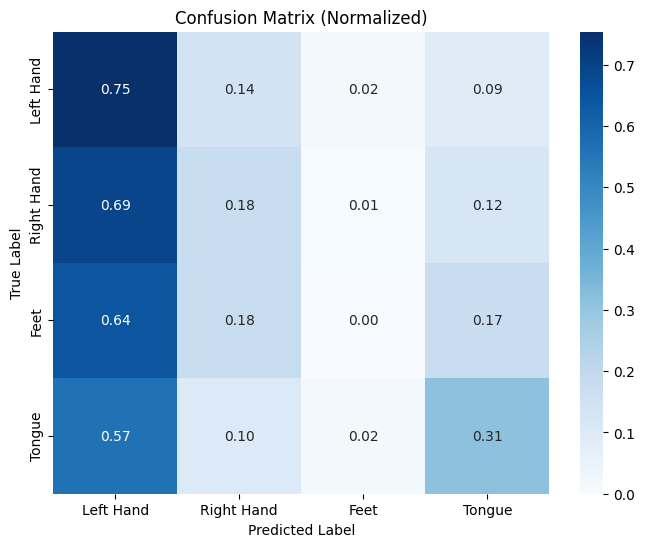

In [7]:
model.load_state_dict(best_model_wts)

# Đánh giá mô hình và trực quan hóa
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for alpha, beta, gamma, y_batch in test_loader:
        alpha = alpha.to(device) 
        beta = beta.to(device)
        gamma = gamma.to(device)
        y_batch = y_batch.to(device)

        outputs = model(alpha, beta, gamma)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Tính toán độ chính xác
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Báo cáo phân loại
print(classification_report(all_labels, all_preds))

# Ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']  # Thay thế bằng tên lớp của bạn

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()